In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.datasets import make_classification, make_blobs, make_spd_matrix
from scipy.spatial.distance import pdist, squareform

import sys
sys.path.append('C:\\Users\\Shagesh\\Documents\\Python Scripts\\python_work\\mantis-master')
from mantis import sdp_km_burer_monteiro
from numpy.linalg import eigh

Populating the interactive namespace from numpy and matplotlib


In [194]:
[X, Y] = make_blobs(1500, 10, 2, shuffle = True)

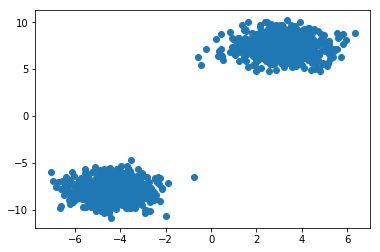

In [195]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [196]:
data = torch.from_numpy(X)

categories = torch.from_numpy(Y)

# Create DataLoader
#dataloader_args = dict(shuffle=True, batch_size=1,num_workers=1, pin_memory=True)
#train_loader = dataloader.DataLoader(train, **dataloader_args)
#test_loader = dataloader.DataLoader(test, **dataloader_args)

In [13]:
Y = sdp_km_burer_monteiro(X, 20, rank=len(X),
                                  tol=1e-6, maxiter=5000, verbose=True)

   0 | Y bounds 0.00000 0.00208 | constraints -18.1700717109 0.1381567038 | E 1.6969094217
   1 | Y bounds 0.00000 0.00300 | constraints -16.8823587494 0.1135191929 | E 0.4510604336
   2 | Y bounds 0.00000 0.00291 | constraints -16.8985246910 0.0469568911 | E 0.0243578676
   3 | Y bounds 0.00000 0.00288 | constraints -16.8986139860 0.0367875543 | E 0.0034836665
   4 | Y bounds 0.00000 0.00288 | constraints -16.8986124030 0.0352643670 | E 0.0010422383
   5 | Y bounds 0.00000 0.00288 | constraints -16.8986040616 0.0343038647 | E 0.0004665305
   6 | Y bounds 0.00000 0.00288 | constraints -16.8986088502 0.0344595154 | E 0.0002971683
   7 | Y bounds 0.00000 0.00288 | constraints -16.8986048754 0.0341643001 | E 0.0002499289
   8 | Y bounds 0.00000 0.00288 | constraints -16.8986233177 0.0346248780 | E 0.0002831622
   9 | Y bounds 0.00000 0.00288 | constraints -16.8985953882 0.0346208792 | E 0.0004357701
  10 | Y bounds 0.00000 0.00289 | constraints -16.8986885045 0.0371496395 | E 0.0009256962

In [123]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

NameError: name 'train' is not defined

## Model

In [301]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_neurons, Wx_in, Wy_in, Y_hat_in, u_plus_in, u_minus_in, Wx_learning_rate, Wy_learning_rate, u_plus_lr, u_minus_lr ):
        super(Model, self).__init__()
        
        self.Wx = Wx_in.float() # n_neurons x n_input
        self.Wy = Wy_in.float() # n_neurons X n_neurons
        self.Y_hat = Y_hat_in.float() # n_neurons x 1
        self.u_plus = u_plus_in.float() # n_neurons x 1
        self.u_minus = u_minus_in.float() # n_neurons x 1
        
        self.Y0 = torch.randn(n_neurons, 1).float() # n_neurons x 1
        self.alpha = torch.randn(1)
        
        self.eta = 0.01 # learning rate
        self.eta_alpha = 0.01 # learning rate        
        self.eta_Wx = Wx_learning_rate
        self.eta_Wy = Wy_learning_rate
        self.eta_u_plus = u_plus_lr
        self.eta_u_minus = u_minus_lr
        self.ceiling = 100 # maximum activity
        self.input_size = n_inputs
        self.neuron_size = n_neurons
        self.error_Wx = 10**5
        self.error_Wy = 10**5
    
    def forward(self, X1):
        X1 = X1.float()
        Y_derivative = 4*torch.mm(self.Wx, X1) - 4*torch.mm(self.Wy, self.Y0) + 0.5*(1 + self.alpha)*self.u_plus + 0.5*(1 - self.alpha)*self.u_minus # batch_size X n_neurons, highest activity 100
        alpha_derivative = 0.5*torch.mm((self.u_plus - self.u_minus).T, self.Y0) - 1 - self.alpha
        return Y_derivative, alpha_derivative
    
    def updateYandalpha(self, Y_in, alpha_in):
        Y_in = Y_in.float()
        self.Y0 = self.Y0 + self.eta*(Y_in)
        self.Y0[self.Y0 < 0] = 0
        self.alpha = self.alpha + self.eta_alpha*(alpha_in)
        if torch.isnan(self.alpha):
            self.alpha = torch.randn(1)
        if torch.isnan(self.Y0).byte().any():
            self.Y0[torch.isnan(self.Y0)] = torch.randn(self.neuron_size, 1).float()[torch.isnan(self.Y0)]
        return self.Y0, self.alpha

    def updateY_hat(self, outputs):
        outputs = outputs.float()
        self.Y_hat += torch.mul(outputs, outputs)
        self.Y_hat[torch.isnan(self.Y_hat)] = 0
        
    def updateWy(self, outputs):
        outputs = outputs.float()
        D = torch.diag(torch.diag(self.Wy))
        change_Wy = torch.mm(outputs, outputs.T) - self.Wy
        self.Wy += self.eta_Wy*change_Wy
        self.Wy = self.Wy - torch.diag(torch.diag(self.Wy)) + D
        self.Wy[torch.isnan(self.Wy)] = torch.randn(self.neuron_size, self.neuron_size).float()[torch.isnan(self.Wy)]

    def updateWx(self, outputs, inputs):
        inputs = inputs.float()
        outputs = outputs.float()
        change_Wx = torch.mm(outputs, inputs.T) - self.Wx
        self.Wx += self.eta_Wx*change_Wx
        self.Wx[torch.isnan(self.Wx)] = torch.randn(self.neuron_size, self.input_size).float()[torch.isnan(self.Wx)]
        
    def updateuplus(self, outputs):
        outputs = outputs.float()
        change_uplus = (self.alpha + 1)*outputs - self.u_plus
        self.u_plus = self.u_plus + self.eta_u_plus*change_uplus
        self.u_plus[torch.isnan(self.u_plus)] = torch.randn(self.neuron_size, 1).float()[torch.isnan(self.u_plus)]

    def updateuminus(self, outputs):
        outputs = outputs.float()
        change_uminus = (1 - self.alpha)*outputs - self.u_minus
        self.u_minus = self.u_minus + self.eta_u_minus*change_uminus
        self.u_minus[torch.isnan(self.u_minus)] = torch.randn(self.neuron_size, 1).float()[torch.isnan(self.u_minus)]


N_INPUT = 10 # number of features in input
N_NEURONS = 20 # number of units in layer
Wx_learning_rate_1 = 10**-2
Wy_learning_rate_1 = 10**-2
uplus_learning_rate_1 = 10**-5
uminus_learning_rate_1 = 10**-5

N_INPUT_2 = 20 # number of features in input
N_NEURONS_2 = 3 # number of units in layer
Wx_learning_rate_2 = 10**-15
Wy_learning_rate_2 = 10**-15
uplus_learning_rate_2 = 10**-15
uminus_learning_rate_2 = 10**-15

model = Model(N_INPUT, N_NEURONS, torch.randn(N_NEURONS, N_INPUT), 1*torch.ones(N_NEURONS, N_NEURONS) - 1*torch.diag(torch.ones(N_NEURONS)), torch.randn(N_NEURONS, 1), torch.randn(N_NEURONS, 1), torch.randn(N_NEURONS, 1), Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_NEURONS_2, N_INPUT_2), 1*torch.ones(N_NEURONS_2, N_NEURONS_2) - 1*torch.diag(torch.ones(N_NEURONS_2)), torch.randn(N_NEURONS_2, 1), torch.randn(N_NEURONS_2, 1), torch.randn(N_NEURONS_2, 1), Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)
criterion = torch.nn.MSELoss()
criterion_check = torch.nn.MSELoss()
model.cuda() # CUDA!
model_2.cuda() # CUDA!

Model()

In [302]:
i = 0

tensor(0.)


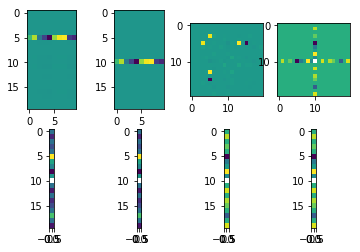

tensor(nan)


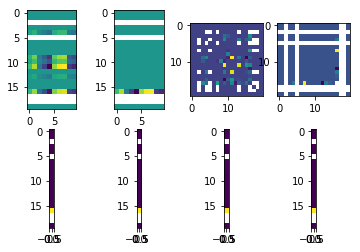

tensor(nan)


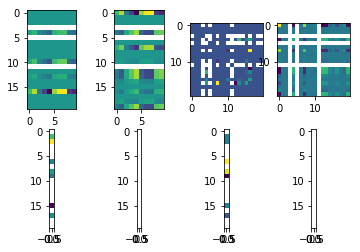

tensor(0.)


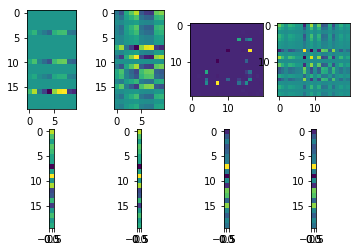

tensor(0.)


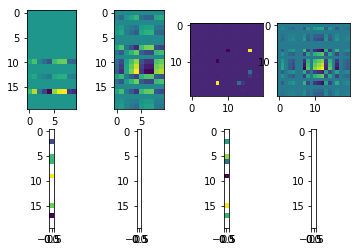

tensor(0.)


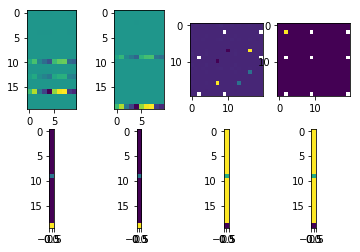

tensor(0.)


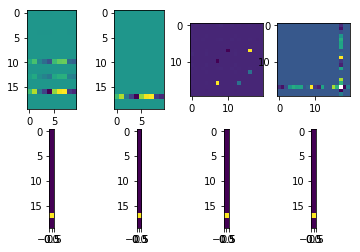

tensor(0.)


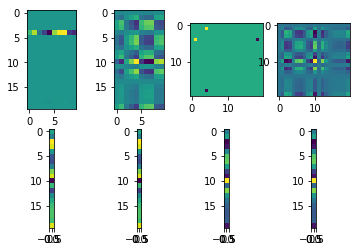

tensor(0.)


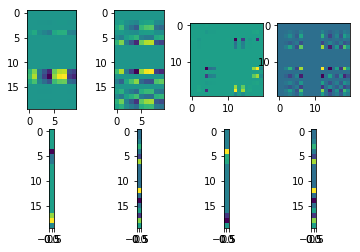

tensor(nan)


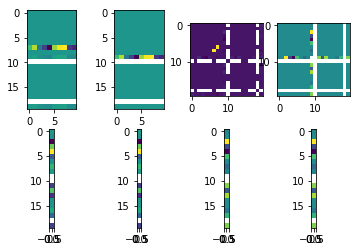

In [306]:
for k in range(100):
    inputs = data[i]
    labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_Wy, model.eta_u_plus, model.eta_u_minus)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_Wy, model_2.eta_u_plus, model_2.eta_u_minus)

    # forward + backward + optimize
    old_output = model.Y0
    old_alpha = model.alpha
    derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
    outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
    loss = criterion(outputs, old_output)
    loss_alpha = criterion(alpha, old_alpha)
        
    j = 0
    while(loss > 10**-5 and j < 10**5):
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, model.Y0)
        loss_alpha = criterion(alpha, old_alpha)
        j += 1
#        print(i, "loss:", loss)
        
    model.updateY_hat(outputs)
    model.updateWx(outputs, inputs.view(-1, 10).T)
    model.updateWy(outputs)        
    model.updateuplus(outputs)        
    model.updateuminus(outputs)        
    if k % 10 == 9:
        print(criterion(outputs, model.Y0))
        f, axarr = plt.subplots(2,4)
        axarr[0, 0].imshow(model.Wx)
        axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(10, 1).T))
        axarr[0, 2].imshow(model.Wy)
        axarr[0, 3].imshow(torch.mm(outputs, outputs.T))
        axarr[1, 0].imshow(model.u_plus)
        axarr[1, 1].imshow((1 + model.alpha)*outputs)
        axarr[1, 2].imshow(model.u_minus)
        axarr[1, 3].imshow((1 - model.alpha)*outputs)
        plt.show()

In [288]:
inputs.shape

torch.Size([10])

tensor(0.)


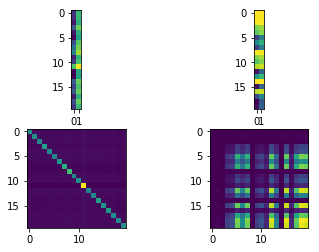

In [52]:
print(criterion(outputs, model.Y0))
f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(model.Wx)
axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(2, 1).T))
axarr[1, 0].imshow(model.Wy)
axarr[1, 1].imshow(torch.mm(outputs, outputs.T))

In [18]:
Y_arranged = Y[np.argsort(categories)]

In [19]:
Q = np.dot(Y_arranged, Y_arranged.T)

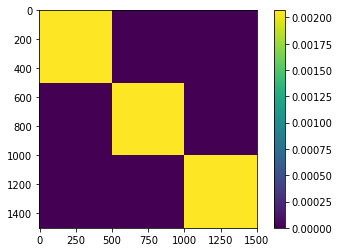

In [20]:
imshow(Q)
colorbar()

In [271]:
Wx_learning_rate_1 = 10**-8
Wy_learning_rate_1 = 10**-8
uplus_learning_rate_1 = 10**-8
uminus_learning_rate_1 = 10**-8

Wx_learning_rate_2 = 10**-8
Wy_learning_rate_2 = 10**-8
uplus_learning_rate_2 = 10**-8
uminus_learning_rate_2 = 10**-8

In [272]:
model.train()
output_compare = torch.ones(3, 3)

losses = []
for epoch in range(1):
    for i in range(1500):
        inputs = data[i]
        labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_Wy, model.eta_u_plus, model.eta_u_minus)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_Wy, model_2.eta_u_plus, model_2.eta_u_minus)

        # forward + backward + optimize
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, old_output)
        loss_alpha = criterion(alpha, old_alpha)
        
        j = 0
        while(loss + loss_alpha > 10**-5 and j < 10**3):
            old_output = model.Y0
            old_alpha = model.alpha
            derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
            outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
            loss = criterion(outputs, model.Y0)
            loss_alpha = criterion(alpha, old_alpha)
            j += 1
#            if j % 100 == 99:
#                print(j, "loss:", loss_alpha)
        
        model.updateY_hat(outputs)
        model.updateWx(outputs, inputs.view(-1, 10).T)
        model.updateWy(outputs)        
        model.updateuplus(outputs)        
        model.updateuminus(outputs)        

        # forward + backward + optimize
        old_output_2 = model_2.Y0
        old_alpha_2 = model_2.alpha
        derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
        outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
        loss_2 = criterion(outputs_2, old_output_2)
        loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        
        j = 0
        while(loss_2 + loss_alpha_2 > 10**-5 and j < 10**3):
            old_output_2 = model_2.Y0
            old_alpha_2 = model_2.alpha
            derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
            outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
            loss_2 = criterion(outputs_2, old_output_2)
            loss_alpha_2 = criterion(alpha_2, old_alpha_2)
            j += 1
#            if j % 1000 == 999:
#                print(j, "loss:", loss)
        
        model_2.updateY_hat(outputs_2)
        model_2.updateWx(outputs_2, outputs)
        model_2.updateWy(outputs_2)        
        model_2.updateuplus(outputs_2)        
        model_2.updateuminus(outputs_2)        
        
        loss_check = criterion_check(outputs_2.T[0], output_compare[labels])
        losses.append(loss_check)
        output_compare[labels] = outputs_2.T
                
        # Display
        if i % 10 == 9:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                i , 
                1500,
                100. * i / 1500, 
                loss_check), 
                end='')
            
    print()

 Train Epoch: 0 [1499/1500 (100%)]	Loss: 3034.3339840000000


In [273]:
#output_compare
distance = torch.zeros((1500, 20))
distance_2 = torch.zeros((1500, 3))
for i in range(1500):
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_Wy, model.eta_u_plus, model.eta_u_minus)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_Wy, model_2.eta_u_plus, model_2.eta_u_minus)
    old_output = model.Y0
    old_alpha = model.alpha
    derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
    outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
    loss = criterion(outputs, old_output)
    loss_alpha = criterion(alpha, old_alpha)
    j = 0
    while(loss + loss_alpha > 10**-5 and j < 10**3):
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, model.Y0)
        loss_alpha = criterion(alpha, old_alpha)
        j += 1
    
    old_output_2 = model_2.Y0
    old_alpha_2 = model_2.alpha
    derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
    outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
    loss_2 = criterion(outputs_2, old_output_2)
    loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        
    j = 0
    while(loss_2 + loss_alpha_2 > 10**-5 and j < 10**3):
        old_output_2 = model_2.Y0
        old_alpha_2 = model_2.alpha
        derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
        outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
        loss_2 = criterion(outputs_2, old_output_2)
        loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        j += 1
    distance[i] = outputs.T
    distance_2[i] = outputs_2.T
            # Display
    if i % 10 == 9:
        print('\r Compute output [{}/{} ({:.0f}%)]\t'.format(
            i , 
            1500,
            100. * i / 1500), 
            end='')
            
print()
#    for j in range(2):
#        distance[j] = torch.nn.functional.mse_loss(outputs[0], output_compare[j])
#    print(outputs_2)
#    print(np.argmin(distance.data.numpy()), '   ', labels)

 Compute output [1499/1500 (100%)]	


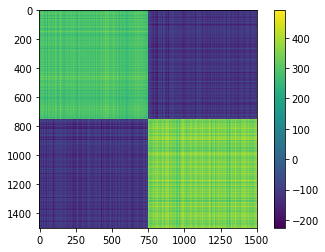

In [275]:
imshow(torch.mm(data[np.argsort(categories)], data[np.argsort(categories)].T))
colorbar()

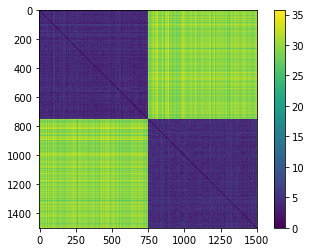

In [276]:
imshow(squareform(pdist(data[np.argsort(categories)])))
colorbar()

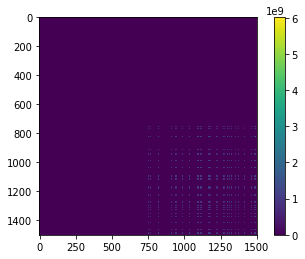

In [278]:
imshow(torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T))
colorbar()

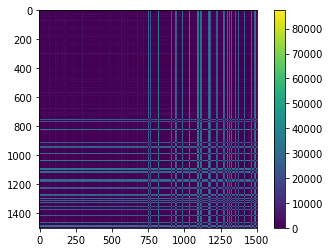

In [279]:
imshow(squareform(pdist(distance[np.argsort(categories)])))
colorbar()

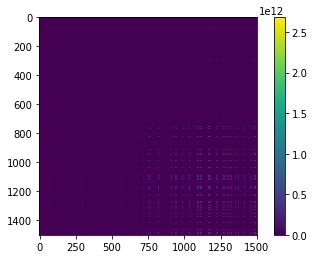

In [280]:
imshow(torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T))
colorbar()

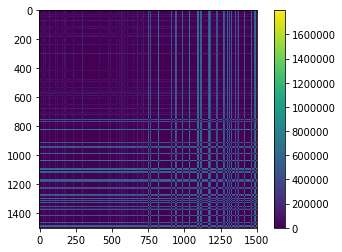

In [281]:
imshow(squareform(pdist(distance_2[np.argsort(categories)])))
colorbar()

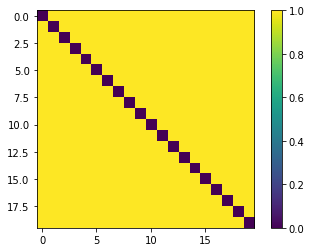

In [282]:
imshow(model.Wy)
colorbar()

In [80]:
for i in range(20):
    plt.scatter(X[:,0], X[:,1], c=distance[:, i], cmap='Greys', alpha=0.1)
    colorbar()
    plt.show()

IndexError: too many indices for tensor of dimension 1

In [21]:
distance

tensor([106.7697,   4.1368,   0.0000])

## Evaluate

In [26]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu().float()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

RuntimeError: matrices expected, got 3D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747

In [110]:
#output_compare
distance = torch.zeros(3)
correct_count = 0
for k in range(100):
    i = k*15
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, Wx_learning_rate_1, Wy_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, Wx_learning_rate_2, Wy_learning_rate_2)
    outputs = model.forward(inputs.flatten().view(-1, 10).T)
    j = 0
    old_output = model.Y0
    derivative = model.forward(inputs.flatten().view(-1, 10).T)
    outputs = model.updateY(derivative)
    loss = criterion(outputs, old_output)
    j = 0
    while(loss > 10**-5 and j < 10**3):
        old_output = model.Y0
        derivative = model.forward(inputs.flatten().view(-1, 10).T)
        outputs = model.updateY(derivative)
        loss = criterion(outputs, old_output)
        j += 1
    old_output_2 = model_2.Y0
    derivative_2 = model_2.forward(outputs)
    outputs_2 = model_2.updateY(derivative_2)
    loss_2 = criterion(outputs_2, old_output_2)
    j = 0
    while(loss_2 > 10**-5 and j < 10**3):
        old_output_2 = model_2.Y0
        derivative_2 = model_2.forward(outputs)
        outputs_2 = model_2.updateY(derivative_2)
        loss_2 = criterion(outputs_2, old_output_2)
        j += 1
#    distance[i] = outputs.T
    for j in range(2):
        distance[j] = torch.nn.functional.mse_loss(outputs_2.T[0], output_compare[j])
#    print(outputs_2.T)
    print(np.argmin(distance.data.numpy()), '   ', labels)
    if np.argmin(distance.data.numpy()) == labels:
        correct_count += 1
print(float(correct_count)/100)

2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtype=torch.int32)
2     tensor(0, dtyp